我们实现 dropout_layer 函数，该函数以dropout的概率丢弃张量输入X中的元素

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃。
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留。
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout) # 1-p意思是=让不丢弃的输入变得更大一点，其实数学上推理出来是为了让输入的期望不变而已

测试dropout_layer函数

In [4]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  8.,  0., 12.,  0.],
        [16., 18., 20., 22.,  0.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元

In [6]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

训练和测试

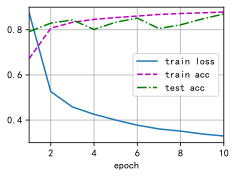

In [7]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

简洁实现

In [8]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    # 在第一个全连接层之后添加一个dropout层
                    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
                    # 在第二个全连接层之后添加一个dropout层
                    nn.Dropout(dropout2), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

对模型进行训练和测试

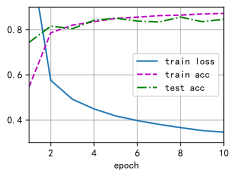

In [9]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)